In [2]:
%matplotlib notebook  
import matplotlib as mpl
import matplotlib.pyplot as plt

import skimage
import numpy as np
import os

from IPython.display import Image
from ipywidgets import interact, interactive, fixed

from skimage import data, filters, io, img_as_float

from io import BytesIO



# Loading and displaying images

We start with a few functions to load images, and display it inline in Jupyter notebooks.

In [3]:
def get_image_path(img_name):
    return 'data/{img_name}/images/{img_name}.png'.format(img_name=img_name)

def get_mask_path(img_name, mask_name):
    return 'data/{img_name}/masks/{mask_name}.png'.format(img_name=img_name, mask_name=mask_name)

def get_all_images(path):
    return [o for o in os.listdir(path) if os.path.isdir(os.path.join(path, o))]

def get_image_masks(path, image):
    mask_dir = os.path.join(path, image, 'masks')
    if os.path.isdir(mask_dir):
        return [o[:-4] for o in os.listdir(mask_dir) if o.endswith('.png')]
    else:
        return []

DATA_PATH = 'data'
ALL_IMAGES = get_all_images(DATA_PATH)
IMG_MASKS = {i: get_image_masks(DATA_PATH, i) for i in ALL_IMAGES}

# this is a helper method from https://github.com/jupyter-widgets/ipywidgets/blob/master/docs/source/examples/Image%20Processing.ipynb

def arr2img(arr):
    """Display a 2- or 3-d numpy array as an image."""
    if arr.ndim == 2:
        format, cmap = 'png', mpl.cm.gray
    elif arr.ndim == 3:
        format, cmap = 'jpg', None
    else:
        raise ValueError("Only 2- or 3-d arrays can be displayed as images.")
    # Don't let matplotlib autoscale the color range so we can control overall luminosity
    vmax = 255 if arr.dtype == 'uint8' else 1.0
    with BytesIO() as buffer:
        mpl.image.imsave(buffer, arr, format=format, cmap=cmap, vmin=0, vmax=vmax)
        out = buffer.getvalue()
    return Image(out)

def show_image(img):
    return arr2img(skimage.io.imread(get_image_path(ALL_IMAGES[img])))

def view_cell_image(i):
    return arr2img(skimage.io.imread(get_image_path(ALL_IMAGES[i])))

We can now define a little viewer to scroll through the dataset.

In [4]:
def view_cell_image(i):
    return arr2img(skimage.io.imread(get_image_path(ALL_IMAGES[i])))

interact(view_cell_image, i=(0,len(ALL_IMAGES)-1))

A Jupyter Widget

<function __main__.view_cell_image>

# Separating images into classes

Our training images belong to different datasets. We can try to segment them back by clustering them according to image intensities. We use the HSV colorspace, and rescale the images by adaptive histogram equalization.

In [13]:
from skimage import exposure
from mpl_toolkits.mplot3d import Axes3D

def sum_image_intensities_colorspace(img, colorspace, rescale=None):
    arr = skimage.io.imread(get_image_path(ALL_IMAGES[img]))
    arr = arr[:,:,:3]
    if rescale is not None:
        arr = rescale(arr)
        
    if colorspace == 'LAB':
        arr = skimage.color.rgb2lab(arr)
    else:
        arr = skimage.color.convert_colorspace(arr, 'RGB', colorspace)
        
    img_shape = arr.shape
    num_pixels = img_shape[0] * img_shape[1]
    flattened_pixels = arr.flatten().reshape(num_pixels, img_shape[2])
    return flattened_pixels.sum(axis=0)[:3] / float(num_pixels)

In [14]:
_IMAGE_INTENSITIES = np.array([sum_image_intensities_colorspace(i, 'HSV', rescale=exposure.equalize_adapthist) for i in range(len(ALL_IMAGES))])


/Users/vaishalilambe/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


<IPython.core.display.Javascript object>


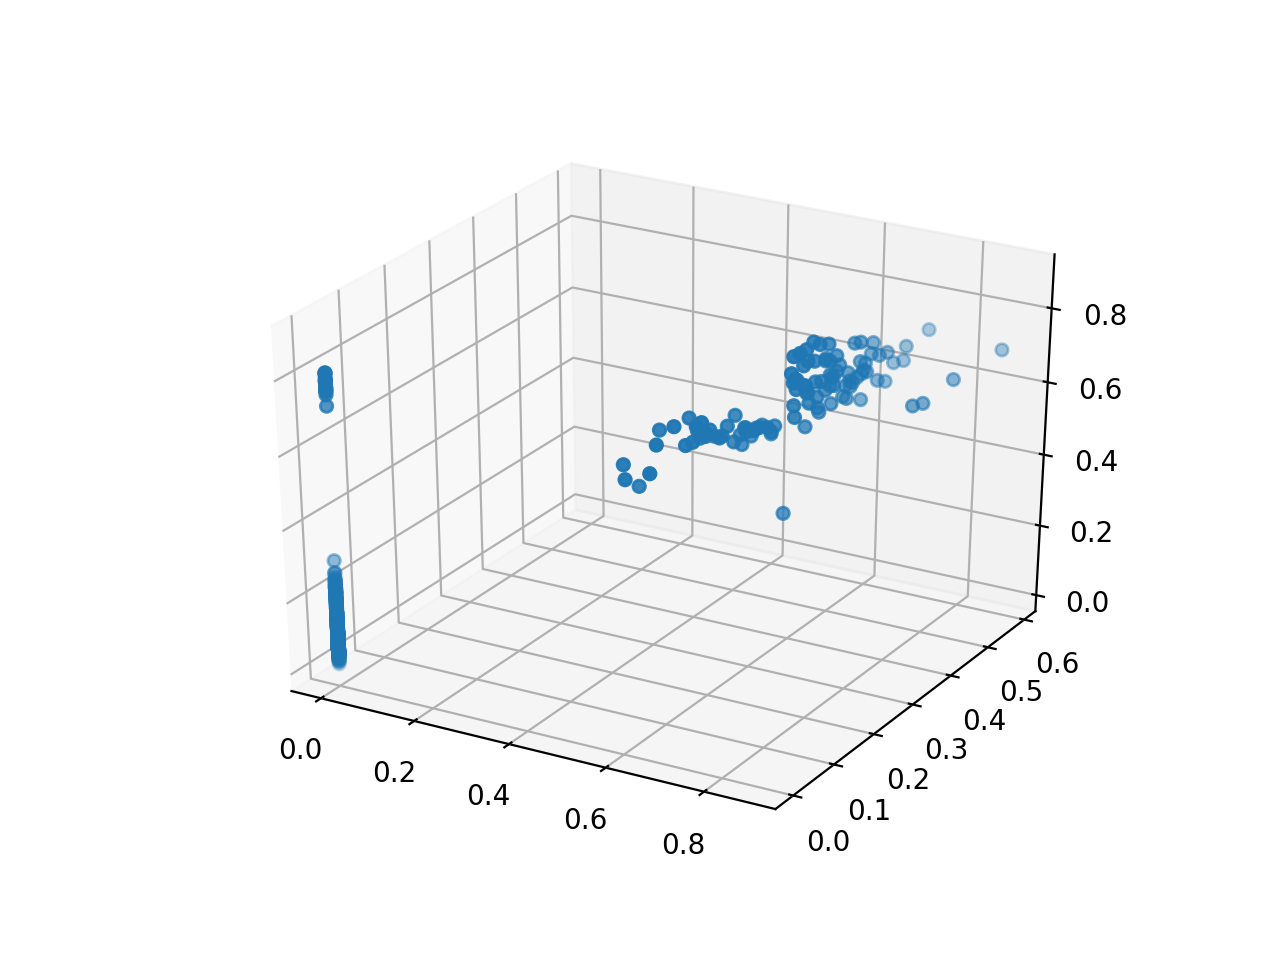

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
n = 100
ax.scatter(_IMAGE_INTENSITIES[:,0], _IMAGE_INTENSITIES[:,1], _IMAGE_INTENSITIES[:,2])

plt.show()

We see that by using H/V pairs, we can probably get some decent results clustering.

In [16]:
from sklearn import metrics
from sklearn import mixture

HV_PAIRS = _IMAGE_INTENSITIES[:,(0,2)]

from numpy import linalg

np.random.seed(42)
gmm = mixture.GaussianMixture(n_components=8, covariance_type='diag')
gmm.fit(HV_PAIRS)

clf = gmm   
X = HV_PAIRS
Y_ = clf.predict(X)



<IPython.core.display.Javascript object>


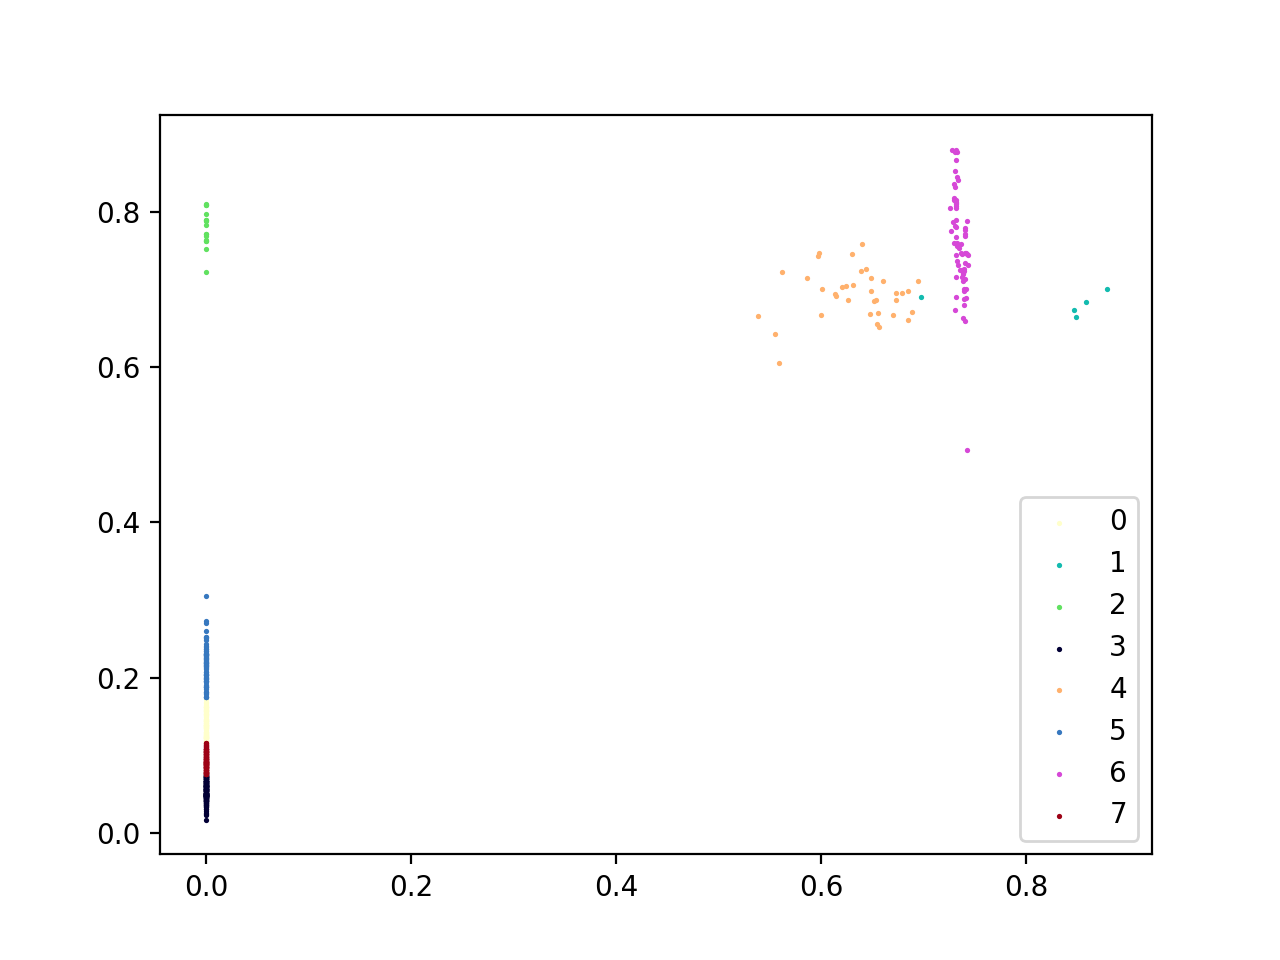

In [17]:
from cycler import cycler
import matplotlib._color_data as mcd


fig = plt.figure()

color_iter = cycler(color=np.random.choice(list(mcd.XKCD_COLORS.values()), 12))
colors = []
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    color = color['color']
    colors += [color]
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color, label='{}'.format(i))

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


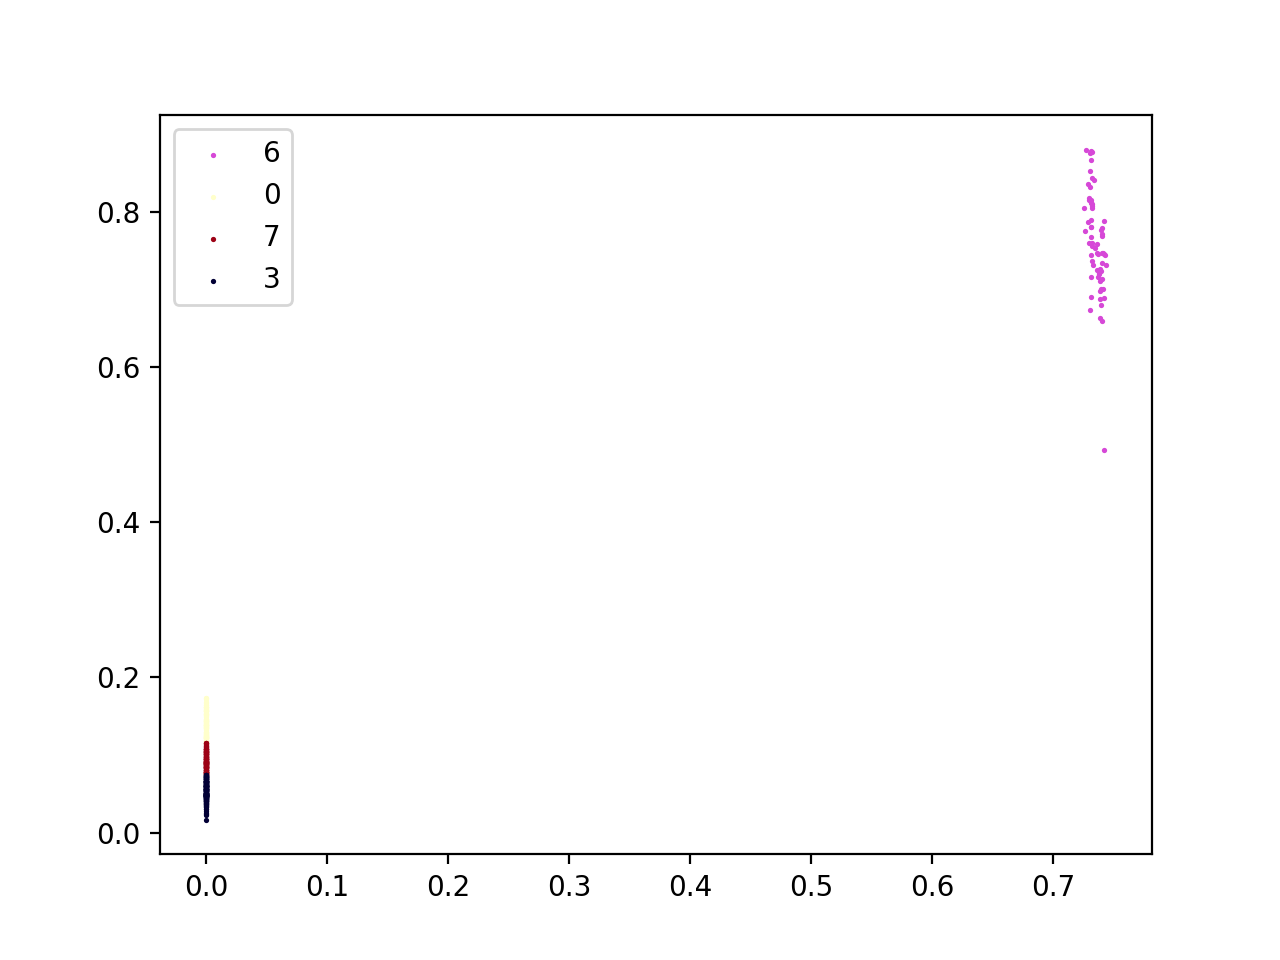

In [19]:

fig = plt.figure()

for i in [6,0,7,3]:
    mean = clf.means_[i]
    color = colors[i]
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color, label='{}'.format(i))

plt.legend()
plt.show()

In [20]:
GROUPS = []
GROUPS.append(np.where((Y_ == 6) | (Y_ == 3) | (Y_ == 0) | (Y_ == 7))[0])
GROUPS.append(np.where((Y_ == 1))[0])
GROUPS.append(np.where((Y_ == 2))[0])
GROUPS.append(np.where((Y_ == 4))[0])
GROUPS.append(np.where((Y_ == 5))[0])

In [21]:
def view_group_cell_images(c_i):
    group = GROUPS[c_i]
    
    def view_images(i):
        arr = skimage.io.imread(get_image_path(ALL_IMAGES[group[i]]))
        print(i)
        return arr2img(arr)

    print("Group: {}, images: {}".format(c_i, len(group)))
    interact(view_images, i=(0,len(group)-1))

interact(view_group_cell_images, c_i=(0,len(GROUPS)-1))

A Jupyter Widget

<function __main__.view_group_cell_images>

# Load and display masks 

We can define some helper functions to look at masks.

In [22]:
def merge_img_masks(img_num):
    masks = IMG_MASKS[ALL_IMAGES[img_num]]
    img = skimage.io.imread(get_image_path(ALL_IMAGES[img_num]))

    mask_arrs = [skimage.io.imread(get_mask_path(ALL_IMAGES[img_num], mask)) for mask in masks]
    result = np.zeros(img.shape[:2])

    for i in range(len(mask_arrs)):
        result[mask_arrs[i] == 255] = i+1
    
    return result

In [23]:
def view_img_masks(i):
    img = skimage.io.imread(get_image_path(ALL_IMAGES[i]))
    masks = merge_img_masks(i)
    colored = skimage.color.label2rgb(masks, img, bg_label=0, alpha=.5)
    return arr2img(colored)

In [24]:
def view_group_cell_images(c_i):
    group = GROUPS[c_i]
    
    def view_images(i):
        img_num = group[i]
        print(img_num, ALL_IMAGES[img_num])
        display(view_img_masks(img_num))
        display(view_cell_image(img_num))

    print("Group: {}, images: {}".format(c_i, len(group)))
    interact(view_images, i=(0,len(group)-1))

interact(view_group_cell_images, c_i=(0,len(GROUPS)-1))

A Jupyter Widget

<function __main__.view_group_cell_images>